In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Activation

In [2]:
tf.__version__

'2.4.0'

In [3]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

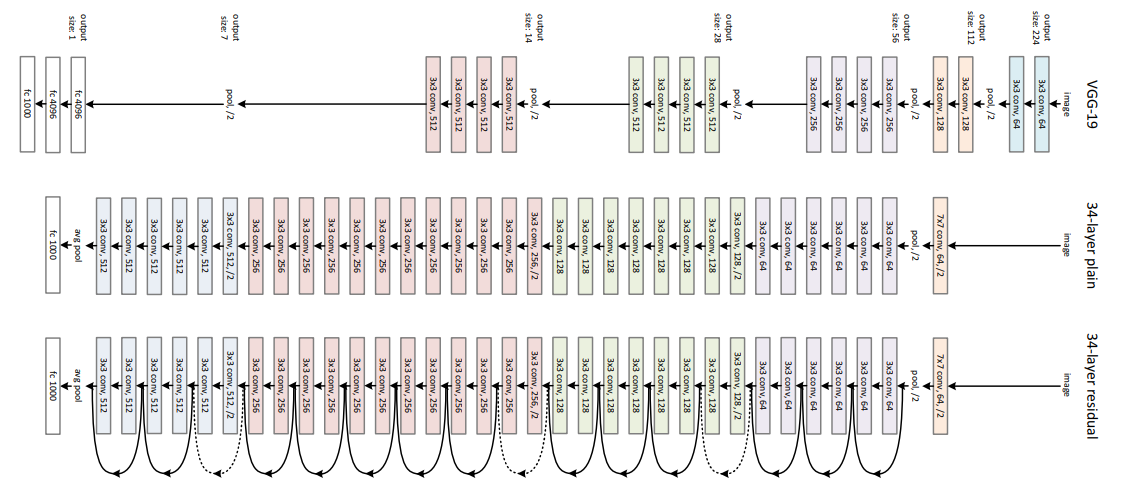

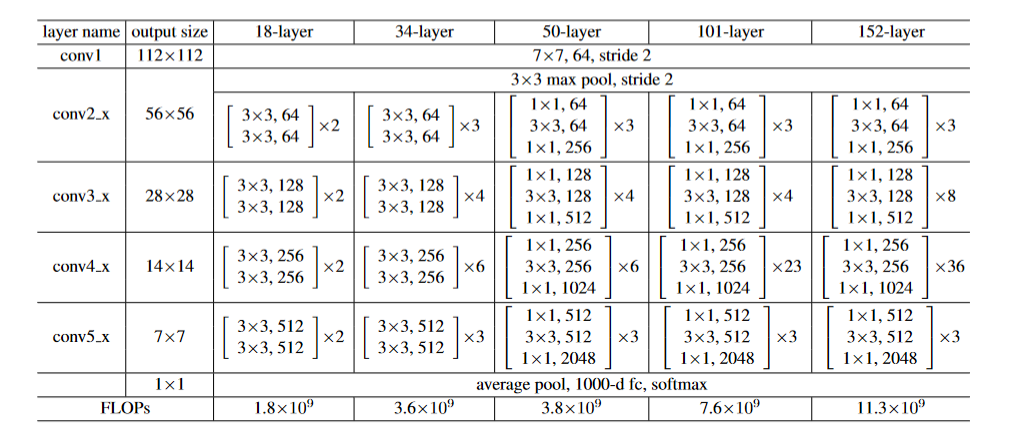

In [5]:
def idendity(x, filters, training=True, stride=1):
    
    if tiny:
        filters = filters//4
    
    xskip = x
    
    x = layers.Conv2D(filters,kernel_size = 1,strides =1, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)
    
    x = layers.Conv2D(filters,kernel_size = 3,strides =1, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)
    
    x = layers.Conv2D(filters*4,kernel_size = 1,strides =1, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
       
    x = tf.nn.relu(tf.keras.layers.add([xskip, x]))
    
    return x


def conv(x, filters, training=True, stride=1):
    
    if tiny:
        filters = filters//4
    
    
    xskip = layers.Conv2D(filters*4,kernel_size = 1,strides =stride, padding = 'valid')(x)
    xskip = layers.BatchNormalization()(xskip)
    
    x = layers.Conv2D(filters,kernel_size = 1,strides =stride, padding = 'valid')(x)
    x = layers.BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)
    
    x = layers.Conv2D(filters,kernel_size = 3,strides =1, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)
    
    x = layers.Conv2D(filters*4,kernel_size = 1,strides =1, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
       
    x = tf.nn.relu(tf.keras.layers.add([xskip, x]))
    
    return x

def ResNet(Num_class, input_shape=(224,224,3), LayerList=[3,4,6,3] ,training=True):
    
    
    X_in = layers.Input(input_shape)
    
    X = layers.Conv2D(filters=64, kernel_size= 7, strides=2, padding="same")(X_in)
    X = layers.BatchNormalization()(X)
    X = layers.Activation(tf.nn.relu)(X)
        
    X = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")(X)
    
    X = conv(X,64,training=True, stride=1)
    X = idendity(X,64)
    if not tiny:
        X = idendity(X,64)
        
    
    X = conv(X,128,training=True, stride=2)
    X = idendity(X,128)
    if not tiny:
        X = idendity(X,128)
        X = idendity(X,128)
        
    
    X = conv(X,256,training=True, stride=2)
    X = idendity(X,256)
    if not tiny:
        X = idendity(X,256)
        X = idendity(X,256)
        X = idendity(X,256)
        X = idendity(X,256)
        
    
    X = conv(X,512,training=True, stride=2)
    X = idendity(X,512)
    if not tiny:
        X = idendity(X,512)
        X = idendity(X,512)
    
    
    X = layers.AveragePooling2D((2, 2), padding='same')(X)

    X = layers.Flatten()(X)
    output = layers.Dense(Num_class, activation='sigmoid', kernel_initializer='he_normal')(X) #multi-class 

    model = tf.keras.Model(inputs=X_in, outputs=output, name='Resnet50')
    
    
    return model      

In [6]:
num_class = 2
tiny = True
final_activation = 'sigmoid'

model = ResNet(1)
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [7]:
import glob
f1 = glob.glob(r'img\train\cats\*.jpg')
f2 = glob.glob(r'img\train\dogs\*.jpg')

import cv2
import numpy as np

x = []
y = []


for i in f1:
    im = cv2.imread(i)
    im = cv2.resize(im, (224,224),interpolation = cv2.INTER_AREA)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    x.append(im*1.0/255)
    y.append(0)  # 0 for cat

for i in f2:
    im = cv2.imread(i)
    im = cv2.resize(im, (224,224),interpolation = cv2.INTER_AREA)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    x.append(im*1.0/255)
    y.append(1)  # 1 for dog

In [8]:
f1 = glob.glob(r'img\validation\cats\*.jpg')
f2 = glob.glob(r'img\validation\dogs\*.jpg')

from PIL import Image
import numpy as np

xv = []
yv = []


for i in f1:
    im = cv2.imread(i)
    im = cv2.resize(im, (224,224),interpolation = cv2.INTER_AREA)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    xv.append(im*1.0/255)
    yv.append(0)  # 0 for cat
    
for i in f2:
    im = cv2.imread(i)
    im = cv2.resize(im, (224,224),interpolation = cv2.INTER_AREA)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    xv.append(im*1.0/255)
    yv.append(1)  # 1 for dog

In [9]:
x = np.array(x)
x.shape

(2000, 224, 224, 3)

In [10]:
y = np.array(y)
y.shape

(2000,)

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])

In [13]:
history = model.fit(x,y,batch_size=16,epochs= 25,shuffle = True, validation_split = .2)

Epoch 1/25
100/100 [==============================] - 16s 152ms/step - loss: 0.7738 - binary_accuracy: 0.6469 - val_loss: 0.8992 - val_binary_accuracy: 0.1975
Epoch 2/25
100/100 [==============================] - 14s 144ms/step - loss: 0.6716 - binary_accuracy: 0.6831 - val_loss: 9.1992 - val_binary_accuracy: 0.0050
Epoch 3/25
100/100 [==============================] - 14s 144ms/step - loss: 0.7214 - binary_accuracy: 0.7063 - val_loss: 0.2364 - val_binary_accuracy: 0.9150
Epoch 4/25
100/100 [==============================] - 14s 144ms/step - loss: 0.6371 - binary_accuracy: 0.7250 - val_loss: 0.4226 - val_binary_accuracy: 0.9125
Epoch 5/25
100/100 [==============================] - 14s 145ms/step - loss: 0.5535 - binary_accuracy: 0.7725 - val_loss: 0.4285 - val_binary_accuracy: 0.8125
Epoch 6/25
100/100 [==============================] - 14s 145ms/step - loss: 0.5414 - binary_accuracy: 0.7588 - val_loss: 83.4011 - val_binary_accuracy: 0.0275
Epoch 7/25
100/100 [=========================

In [14]:
pred  = model.predict(np.array(xv[:])).reshape(-1)
pred = np.rint(pred)

In [15]:
sum(pred==np.array(yv)*1.0)/len(pred)

0.622

In [16]:
fx = glob.glob(r'test\*.jpg')
xt = []

for i in fx:
    im = cv2.imread(i)
    im = cv2.resize(im, (224,224),interpolation = cv2.INTER_AREA)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    xt.append(im*1.0/255)
xt = np.array(xt)

In [17]:
xt.shape

(8, 224, 224, 3)

In [18]:
np.rint(model.predict(np.array(xt[:])).reshape(-1))

array([0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [19]:
fx

['test\\0 (1).jpg',
 'test\\0 (2).jpg',
 'test\\0 (3).jpg',
 'test\\0 (4).jpg',
 'test\\1 (1).jpg',
 'test\\1 (2).jpg',
 'test\\1 (3).jpg',
 'test\\1 (4).jpg']

In [21]:
model.predict(np.array(xt[:]))  # super confident when predicting dog. Slight hesitation in predicting cat.

array([[0.04935938],
       [0.6828754 ],
       [0.83489287],
       [0.0054791 ],
       [1.        ],
       [0.9999157 ],
       [1.        ],
       [0.99999964]], dtype=float32)

In [22]:
def op(pred,true):
    th = np.linspace(0,1,20)
    r = []
    for i in th:
        predx = pred*1
        
        predx[predx>=i] = 1
        predx[predx<i]  = 0
        
        r.append(sum(predx==np.array(true)*1.0)/len(predx))
    return r

In [24]:
pred  = model.predict(np.array(xv[:])).reshape(-1)
r = op(pred,np.array(yv))

MemoryError: Unable to allocate 1.12 GiB for an array with shape (1000, 224, 224, 3) and data type float64

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0,1,20),r)
plt.show(r)

In [ ]:
(np.round(pred,2))